In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose, Lambda
from typing import Tuple
from tqdm import tqdm
from pylab import rcParams
import copy
import time
import numpy as np
import torch.nn.utils.prune as prune


%matplotlib inline

In [2]:
def calculate_mean_and_std() -> Tuple[float, float]:
    train_data = MNIST(root='.', download=True, train=True, transform=ToTensor())
    mean = (train_data.data.type(torch.float32) / 255).mean().item()
    std = (train_data.data.type(torch.float32) / 255).std().item()
    return mean, std

def calculate_mean_and_std() -> Tuple[float, float]:
    loader = torch.utils.data.DataLoader(
        MNIST(
            root='.',
            download=True,
            train=True,
            transform=ToTensor()
        )
    )
    n = len(loader.dataset)
    mean = 0
    std = 0
    for x, _ in loader:
        mean += x.mean()
    mean /= n
    for x, _ in loader:
        std += ((x - mean)**2).mean()
    std = torch.sqrt(std/n)
    return mean, std


mean, std = calculate_mean_and_std()

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_data = MNIST(root='.', 
                   download=True, 
                   train=True, 
                   transform=Compose([ToTensor(), 
                                      Normalize((mean,), (std,)),
                                      Lambda(lambda x: x.view(-1))]))

test_data = MNIST(root='.', 
                  download=True, 
                  train=False, 
                  transform=Compose([ToTensor(), 
                                     Normalize((mean,), (std,)),
                                     Lambda(lambda x: x.view(-1))]))

In [5]:
batch_size = 128

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(500, 200)
        self.fc5 = nn.Linear(200, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        out = self.fc5(x)
        return out

In [8]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [9]:
number_epochs = 10


In [10]:
training_losses = []
training_accuracies = []

for epoch in range(number_epochs):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #print(loss)
        # print statistics
        running_loss += loss.item()
        #print(running_loss)
       # if i % 20 == 19:    # print every 2000 mini-batches
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0
        #running_loss+=loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    training_losses.append(running_loss/total)
    training_accuracies.append(correct/total)

print('Finished Training')

Finished Training


Text(0, 0.5, 'Training Accuracy')

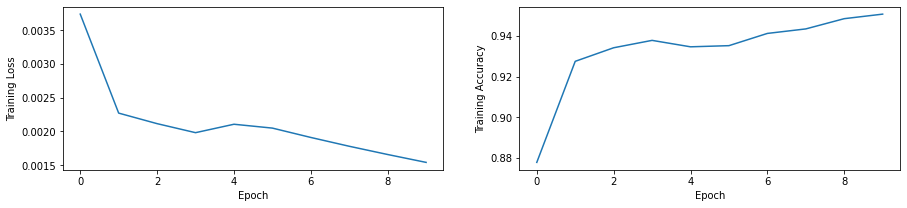

In [11]:
plt.figure(1, figsize=(15, 3))
plt.subplot(121)
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.subplot(122)
plt.plot(training_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')

In [13]:
def test(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data = data
            target = target
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total+=target.size(0)
            correct+=(predicted==target).sum().item()
    return correct/total

In [19]:
original_accuracy = test(model, test_loader)
original_accuracy

100%|██████████| 79/79 [00:03<00:00, 25.55it/s]


0.947

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 94 %


In [15]:
copy_of_model2 = copy.deepcopy(model)

In [21]:
percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def pruning_mult(net, percentage, test_loader):
  copy_of_model3 = copy.deepcopy(net)
  for name, module in copy_of_model3.named_modules():
    # prune 20% of connections in all 2D-conv layers
    if isinstance(module, torch.nn.Linear):
      prune.l1_unstructured(module, name='weight', amount=percentage)
  return test(copy_of_model3 , test_loader)


In [22]:
prune_accuracy = []
for percentage in percentage_list:
  prune_accuracy.append(pruning_mult(model, percentage, test_loader))

100%|██████████| 79/79 [00:03<00:00, 23.06it/s]


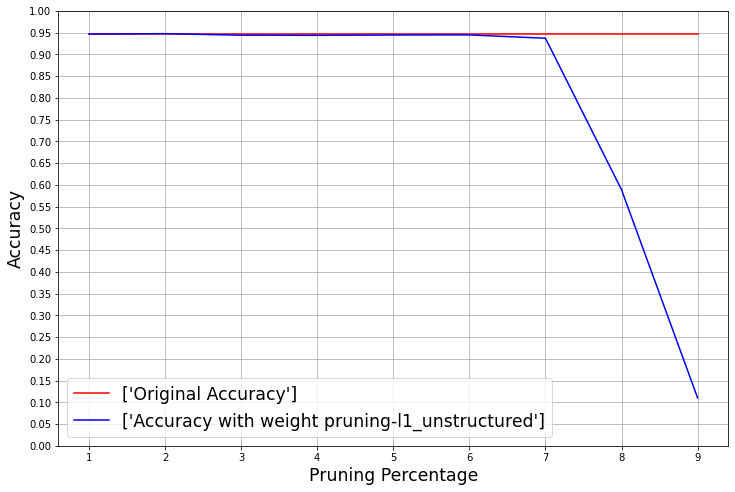

In [60]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, prune_accuracy, 'b')
plt.grid()
plt.legend([['Original Accuracy'], 
            ['Accuracy with weight pruning-l1_unstructured']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

In [24]:
percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def pruning_rs(net, percentage, test_loader):
  copy_of_model = copy.deepcopy(net)
  for name, module in copy_of_model.named_modules():
    if isinstance(module, torch.nn.Linear):
      prune.random_structured(module, name='weight', amount=percentage, dim=1)
  return test(copy_of_model , test_loader)


In [25]:
prune_accuracy_rs = []
for percentage in percentage_list:
  prune_accuracy_rs.append(pruning_rs(model, percentage, test_loader))

100%|██████████| 79/79 [00:03<00:00, 22.87it/s]


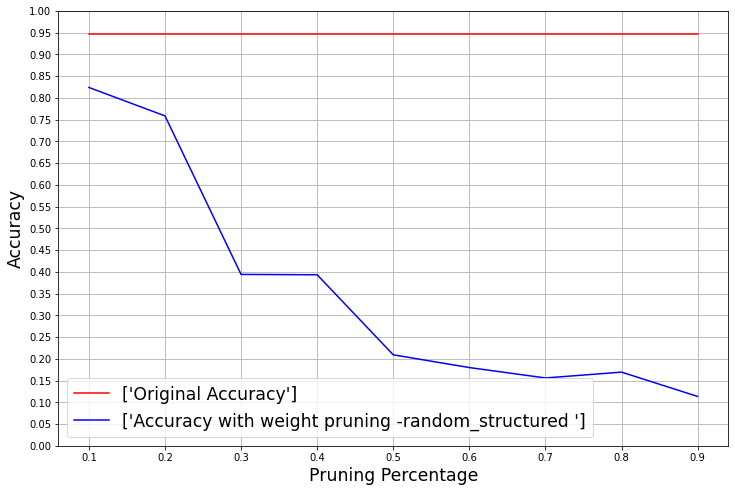

In [30]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, prune_accuracy_rs, 'b')
plt.grid()
plt.legend([['Original Accuracy'], 
            ['Accuracy with weight pruning -random_structured ']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

In [27]:
percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def pruning_lns(net, percentage, test_loader):
  copy_of_model = copy.deepcopy(net)
  for name, module in copy_of_model.named_modules():
    if isinstance(module, torch.nn.Linear):
      prune.ln_structured(module, name='weight', amount=percentage, dim=1, n=float('-inf'))
  return test(copy_of_model , test_loader)

In [28]:
prune_accuracy_lns = []
for percentage in percentage_list:
  prune_accuracy_lns.append(pruning_lns(model, percentage, test_loader))

100%|██████████| 79/79 [00:03<00:00, 23.26it/s]


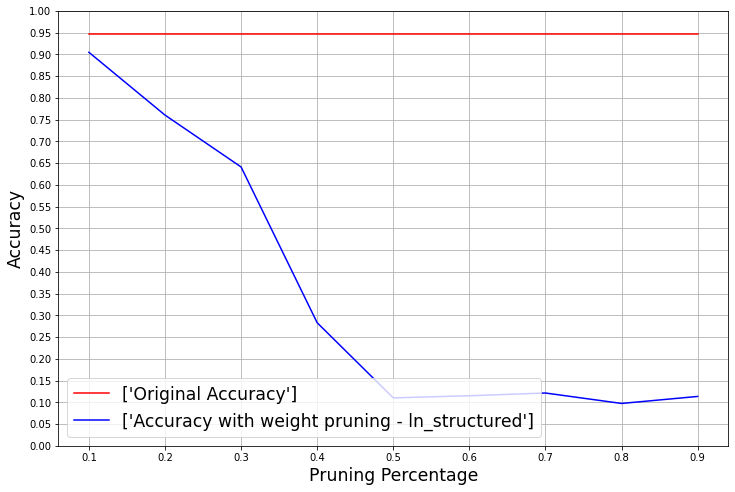

In [31]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, prune_accuracy_lns, 'b')
plt.grid()
plt.legend([['Original Accuracy'], 
            ['Accuracy with weight pruning - ln_structured']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

In [35]:
percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def pruning_ru(net, percentage, test_loader):
  copy_of_model = copy.deepcopy(net)
  for name, module in copy_of_model.named_modules():
    if isinstance(module, torch.nn.Linear):
      prune.random_unstructured(module, name='weight', amount=percentage)
  return test(copy_of_model , test_loader)

In [107]:
prune_accuracy_ru = []
for percentage in percentage_list:
  prune_accuracy_ru.append(pruning_ru(model, percentage, test_loader))

100%|██████████| 79/79 [00:03<00:00, 22.63it/s]


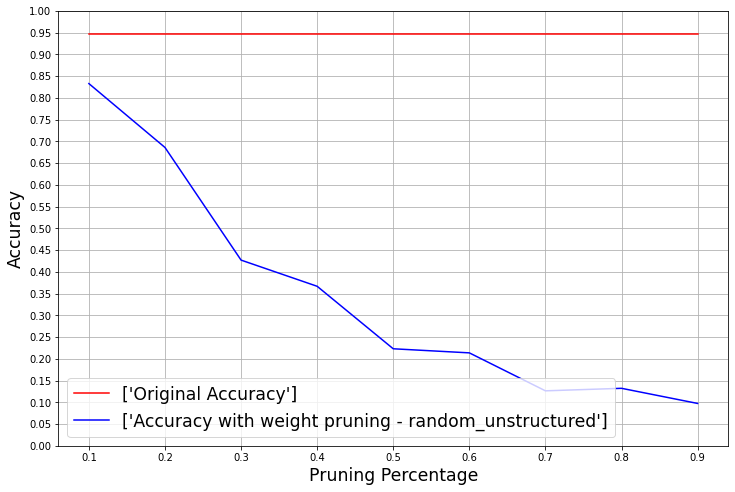

In [37]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, prune_accuracy_ru, 'b')
plt.grid()
plt.legend([['Original Accuracy'], 
            ['Accuracy with weight pruning - random_unstructured']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

In [45]:
percentage_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

def pruning_bias(net, percentage, test_loader):
  copy_of_model = copy.deepcopy(net)
  for name, module in copy_of_model.named_modules():
    if isinstance(module, torch.nn.Linear):
      prune.l1_unstructured(module, name='bias', amount=percentage)
  return test(copy_of_model , test_loader)

In [46]:
prune_accuracy_bias = []
for percentage in percentage_list:
  prune_accuracy_bias.append(pruning_bias(model, percentage, test_loader))

100%|██████████| 79/79 [00:03<00:00, 24.52it/s]


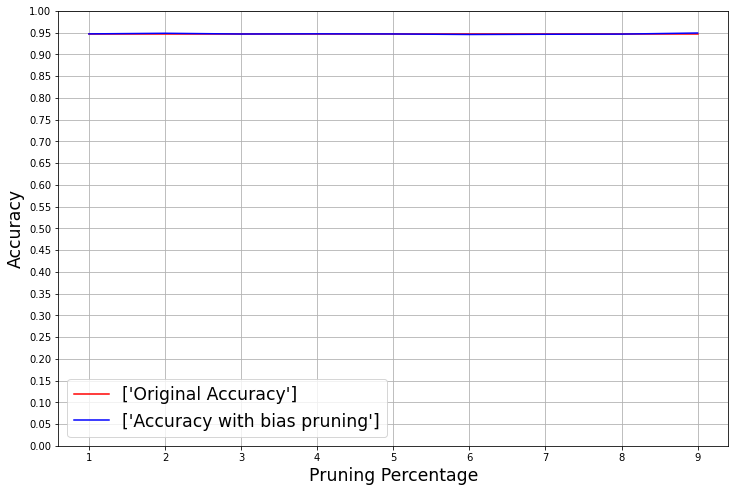

In [50]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, prune_accuracy_bias, 'b')
plt.grid()
plt.legend([['Original Accuracy'], 
            ['Accuracy with bias pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

In [47]:
percentage_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

def pruning_bias_ru(net, percentage, test_loader):
  copy_of_model = copy.deepcopy(net)
  for name, module in copy_of_model.named_modules():
    if isinstance(module, torch.nn.Linear):
      prune.random_unstructured(module, name='bias', amount=percentage)
  return test(copy_of_model , test_loader)

In [106]:
prune_accuracy_bias_ru = []
for percentage in percentage_list:
  prune_accuracy_bias_ru.append(pruning_bias_ru(model, percentage, test_loader))

100%|██████████| 79/79 [00:03<00:00, 24.82it/s]


ValueError: ignored

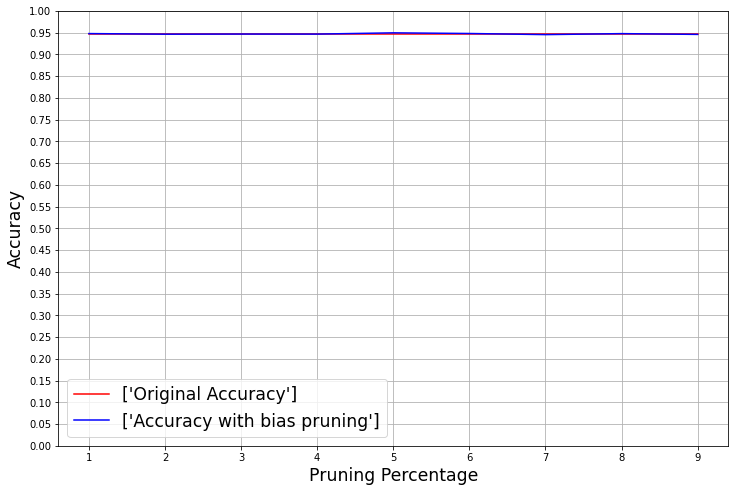

In [51]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, prune_accuracy_bias_ru, 'b')
plt.grid()
plt.legend([['Original Accuracy'], 
            ['Accuracy with bias pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

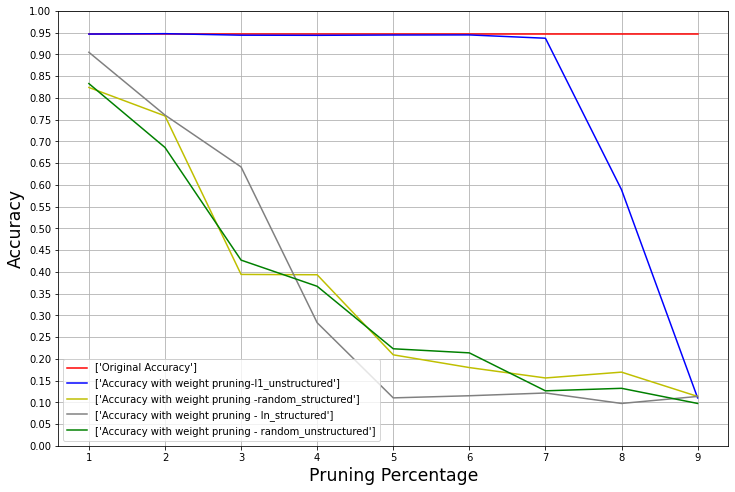

In [63]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, prune_accuracy, 'b',
         percentage_list, prune_accuracy_rs, 'y',
         percentage_list, prune_accuracy_lns, 'grey',
         percentage_list, prune_accuracy_ru, 'g',
         )
plt.grid()
plt.legend([['Original Accuracy'],
            ['Accuracy with weight pruning-l1_unstructured'], 
            ['Accuracy with weight pruning -random_structured'],
            ['Accuracy with weight pruning - ln_structured'],
            ['Accuracy with weight pruning - random_unstructured'],
            ], 
           loc='lower left')#, fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

In [69]:
percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
def pruning_global(net, percentage, test_loader):
  copy_of_model = copy.deepcopy(net)
  parameters_to_prune = (
    (copy_of_model.fc1, 'weight'),
    (copy_of_model.fc2, 'weight'),
    (copy_of_model.fc3, 'weight'),
    (copy_of_model.fc4, 'weight'),
    (copy_of_model.fc5, 'weight'),)
  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.RandomUnstructured,
    amount=percentage,)

  return test(copy_of_model , test_loader)

In [70]:
global_accuracy = []
for percentage in percentage_list:
  global_accuracy.append(pruning_global(model, percentage, test_loader))

100%|██████████| 79/79 [00:03<00:00, 23.09it/s]


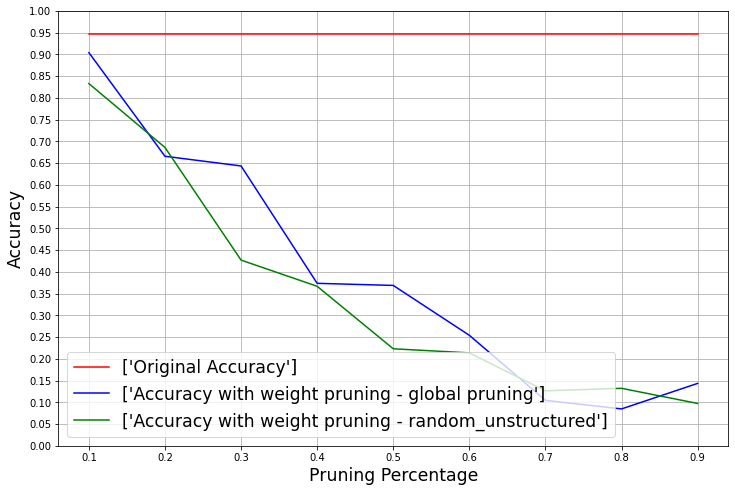

In [79]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, global_accuracy, 'b',
         percentage_list, prune_accuracy_ru, 'g')
plt.grid()
plt.legend([['Original Accuracy'], 
            ['Accuracy with weight pruning - global pruning'],
            ['Accuracy with weight pruning - random_unstructured'],
            ],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

In [72]:
percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
def pruning_global_l1u(net, percentage, test_loader):
  copy_of_model = copy.deepcopy(net)
  parameters_to_prune = (
    (copy_of_model.fc1, 'weight'),
    (copy_of_model.fc2, 'weight'),
    (copy_of_model.fc3, 'weight'),
    (copy_of_model.fc4, 'weight'),
    (copy_of_model.fc5, 'weight'),)
  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=percentage,)

  return test(copy_of_model , test_loader)

In [73]:
print(percentage_list)
global_l1u_accuracy = []
for percentage in percentage_list:
  global_l1u_accuracy.append(pruning_global_l1u(model, percentage, test_loader))

  0%|          | 0/79 [00:00<?, ?it/s]

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


100%|██████████| 79/79 [00:03<00:00, 23.19it/s]


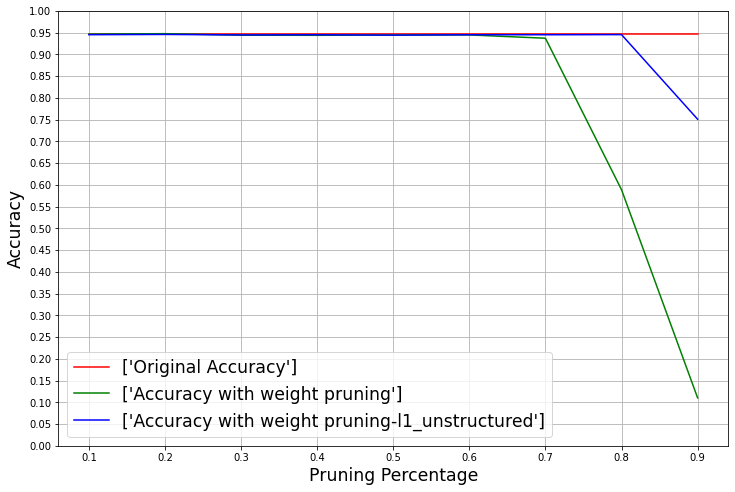

In [77]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, prune_accuracy, 'g',
         percentage_list, global_l1u_accuracy, 'b',)
plt.grid()
plt.legend([['Original Accuracy'], 
            ['Accuracy with weight pruning-l1_unstructured'],
            ['Accuracy with weight global pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

In [83]:
percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
def pruning_global_l1uf(net, percentage, test_loader):
  copy_of_model = copy.deepcopy(net)
  parameters_to_prune = (
    (copy_of_model.fc1, 'weight'),
    (copy_of_model.fc2, 'weight'),
    (copy_of_model.fc5, 'weight'),)
  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=percentage,)

  return test(copy_of_model , test_loader)

In [84]:
print(percentage_list)
global_l1uf_accuracy = []
for percentage in percentage_list:
  global_l1uf_accuracy.append(pruning_global_l1uf(model, percentage, test_loader))

  0%|          | 0/79 [00:00<?, ?it/s]

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


100%|██████████| 79/79 [00:03<00:00, 23.46it/s]


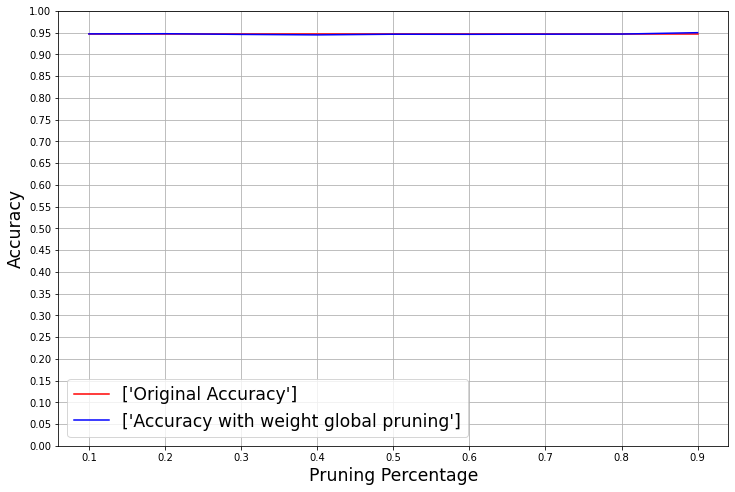

In [85]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, global_l1uf_accuracy, 'b')
plt.grid()
plt.legend([['Original Accuracy'], 
            ['Accuracy with weight global pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

In [94]:
percentage_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
def pruning_global_l1ub(net, percentage, test_loader):
  copy_of_model = copy.deepcopy(net)
  parameters_to_prune = (
    (copy_of_model.fc1, 'weight'),
    (copy_of_model.fc2, 'weight'),
    (copy_of_model.fc3, 'bias'),
    (copy_of_model.fc4, 'weight'),
    (copy_of_model.fc5, 'weight'),)
  prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=percentage,)

  return test(copy_of_model , test_loader)

In [95]:
print(percentage_list)
global_l1ub_accuracy = []
for percentage in percentage_list:
  global_l1ub_accuracy.append(pruning_global_l1ub(model, percentage, test_loader))

  0%|          | 0/79 [00:00<?, ?it/s]

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


100%|██████████| 79/79 [00:03<00:00, 23.86it/s]


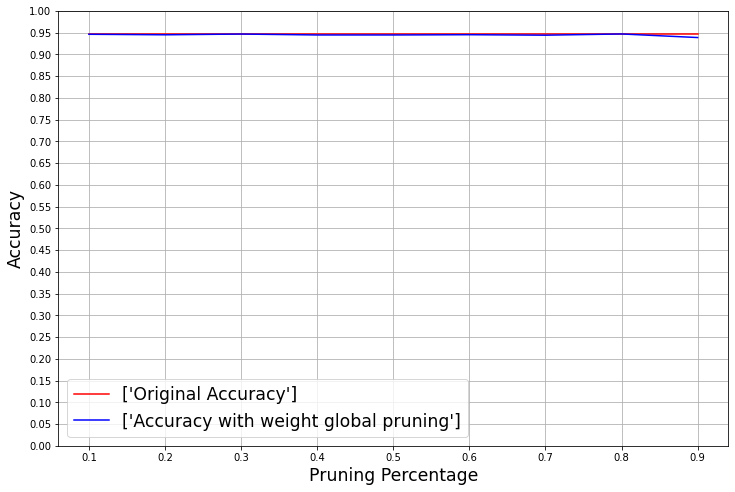

In [96]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, global_l1ub_accuracy, 'b')
plt.grid()
plt.legend([['Original Accuracy'], 
            ['Accuracy with weight global pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

In [97]:
def pruning_weight(net, percentage, test_loader):
  pruning_model = copy.deepcopy(model)
  length = len(list(pruning_model.parameters()))
  print(length)  
  for i, z in enumerate(pruning_model.parameters()):
    if len(z.size())!=1 and i<length-2:
        weight = z.detach().cpu().numpy()
        weight[np.abs(weight)<np.percentile(np.abs(weight), percentage)] = 0
        weight = torch.from_numpy(weight)
        z.data = weight
  return test(pruning_model, test_loader)

  

In [98]:
percentage_list = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]

In [99]:
weight_accuracy = []
for percentage in percentage_list:
  weight_accuracy.append(pruning_weight(model, percentage, test_loader))

  4%|▍         | 3/79 [00:00<00:02, 25.63it/s]

10


  4%|▍         | 3/79 [00:00<00:03, 25.10it/s]

10


  4%|▍         | 3/79 [00:00<00:02, 25.64it/s]

10


  4%|▍         | 3/79 [00:00<00:03, 24.49it/s]

10


  4%|▍         | 3/79 [00:00<00:03, 25.26it/s]

10


  4%|▍         | 3/79 [00:00<00:02, 25.68it/s]

10


  4%|▍         | 3/79 [00:00<00:02, 26.09it/s]

10


  4%|▍         | 3/79 [00:00<00:02, 25.70it/s]

10


  4%|▍         | 3/79 [00:00<00:02, 26.30it/s]

10


  4%|▍         | 3/79 [00:00<00:03, 25.21it/s]

10


  4%|▍         | 3/79 [00:00<00:02, 25.48it/s]

10


  4%|▍         | 3/79 [00:00<00:03, 23.86it/s]

10


100%|██████████| 79/79 [00:03<00:00, 24.87it/s]


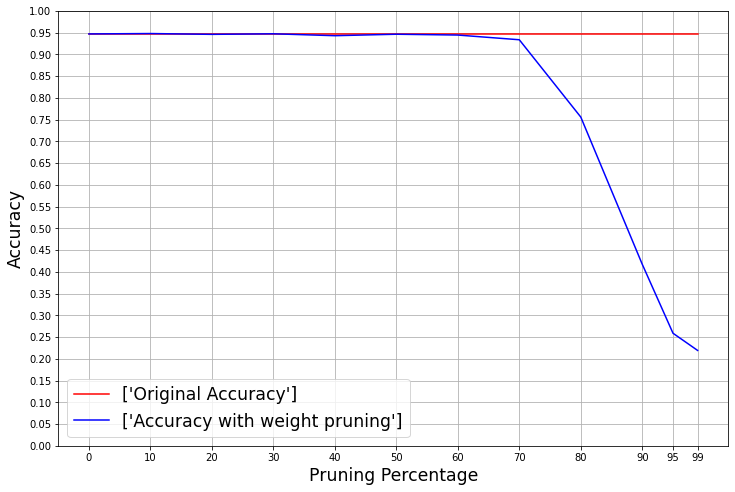

In [100]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, weight_accuracy, 'b')
plt.grid()
plt.legend([['Original Accuracy'], 
            ['Accuracy with weight pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

In [101]:
def pruning_neuron(net, percentage, test_loader):
  pruning_model = copy.deepcopy(model)
  length = len(list(pruning_model.parameters()))
  print(length)  
  for i, z in enumerate(pruning_model.parameters()):
    if len(z.size())!=1 and i<length-2:
        weight = z.detach().cpu().numpy()
        norm = np.linalg.norm(weight, axis=0)
        weight[:, np.argwhere(norm<np.percentile(norm, percentage))] = 0
        weight = torch.from_numpy(weight)
        z.data = weight
  return test(pruning_model, test_loader)

In [102]:
neuron_accuracy = []
for percentage in percentage_list:
  neuron_accuracy.append(pruning_neuron(model, percentage, test_loader))

  4%|▍         | 3/79 [00:00<00:03, 24.34it/s]

10


  4%|▍         | 3/79 [00:00<00:03, 23.13it/s]

10


  4%|▍         | 3/79 [00:00<00:02, 26.53it/s]

10


  4%|▍         | 3/79 [00:00<00:02, 26.58it/s]

10


  4%|▍         | 3/79 [00:00<00:03, 24.41it/s]

10


  4%|▍         | 3/79 [00:00<00:03, 25.26it/s]

10


  4%|▍         | 3/79 [00:00<00:02, 25.96it/s]

10


  4%|▍         | 3/79 [00:00<00:03, 24.69it/s]

10


  4%|▍         | 3/79 [00:00<00:02, 26.28it/s]

10


  4%|▍         | 3/79 [00:00<00:03, 23.05it/s]

10


  4%|▍         | 3/79 [00:00<00:03, 25.21it/s]

10


  4%|▍         | 3/79 [00:00<00:02, 26.35it/s]

10


100%|██████████| 79/79 [00:03<00:00, 25.31it/s]


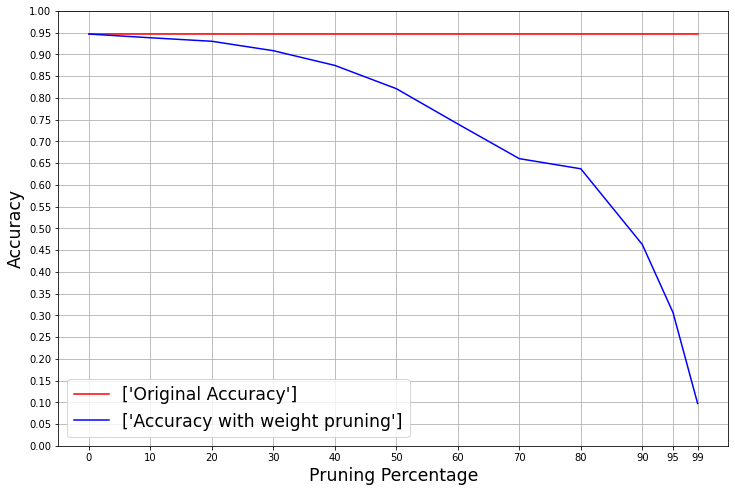

In [103]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, neuron_accuracy, 'b')
plt.grid()
plt.legend([['Original Accuracy'], 
            ['Accuracy with weight pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

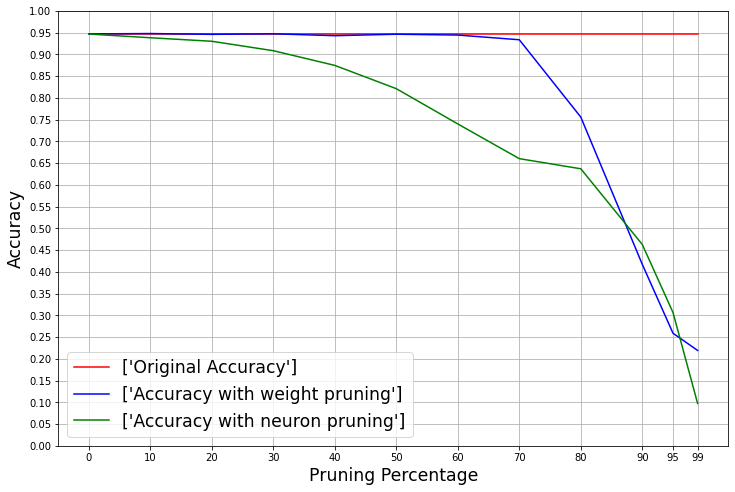

In [104]:
rcParams['figure.figsize'] = 12, 8
plt.plot(percentage_list, np.size(percentage_list)*[original_accuracy], 'r',
         percentage_list, weight_accuracy, 'b',
         percentage_list, neuron_accuracy, 'g')
plt.grid()
plt.legend([['Original Accuracy'],
            ['Accuracy with weight pruning'], 
            ['Accuracy with neuron pruning']], 
           loc='lower left', fontsize='xx-large')
plt.xlabel('Pruning Percentage', fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.xticks(percentage_list)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()